<font size=7 color ="#5499C7" >AI CA6 - Reinforcement Learning</font>
- <font size=5>__Name__ : Kourosh Sajjadi</font>
- <font size=5>__UID__  : 810100587</font>

<p align="justify"><font size="5" color="#A9CCE3"><b>Section 0: Basic Concepts and Problem Goals</b></font><br></p>

<p align="justify">
Welcome to our project on Reinforcement Learning (RL). Our primary objective is to train a snake agent to compete in a 1v1 scenario effectively. This project involves several complex tasks, including managing large state spaces and optimizing the agent's decision-making process.

Reinforcement Learning is a type of machine learning where an agent learns to make decisions by performing certain actions and receiving rewards or penalties in return. The goal is to maximize the cumulative reward over time. In the context of our project, the snake agent will learn strategies to outmaneuver its opponent and survive as long as possible.

We employ various methods to handle the large state spaces that come with the game environment. Techniques such as function approximation, deep learning, and state-space reduction are crucial for efficient training and performance of the snake agent.

Through this project, we aim to demonstrate the application of RL techniques in a competitive setting, showcasing the potential and challenges of training intelligent agents in complex environments.
</p>


#### <p align="justify"><font size="5" color="#d62b5b">What Are Some Ways That We Can Handle Large State Spaces in Q-Learning Algorithms Effectively?</font></p>
<p align="justify">
Handling large state spaces in Q-Learning algorithms can be challenging. However, there are several effective methods to manage this complexity:

1. **Function Approximation**: This method involves using a function, often a neural network, to approximate the Q-values instead of storing them in a table. This approach allows the algorithm to generalize from seen states to unseen states, making it feasible to handle large or continuous state spaces.

2. **Dimensionality Reduction**: Techniques such as Principal Component Analysis (PCA) or t-Distributed Stochastic Neighbor Embedding (t-SNE) can be used to reduce the number of dimensions in the state space. By simplifying the state representation, the Q-Learning algorithm can process and learn from the data more efficiently.

3. **Hierarchical Learning**: This method decomposes the learning task into a hierarchy of smaller, more manageable sub-tasks. By learning policies for sub-tasks and combining them, the agent can handle more complex environments with large state spaces. Hierarchical learning can significantly improve learning efficiency and performance in complex domains.

By employing these methods, we can enhance the capability of Q-Learning algorithms to effectively manage and learn from large state spaces.
</p>


<p align="justify"><font size="5" color="#A9CCE3"><b>Section 1: Using Q-Learning To Model A Snake Agent</b></font><br></p>

In [1]:
import random
import pygame

import numpy as np
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
SNAKE_1_Q_TABLE = "s1_qtble"
SNAKE_2_Q_TABLE = "s2_qtble"

WIDTH = 500
HEIGHT = 500

ROWS = 20

VISION_RANGE = 5
EXTENDED_HEIGHT = HEIGHT + 100

In [3]:
def redrawWindow(snake_1, snake_2, snack, win):
    win.fill((0, 0, 0))
    drawGrid(WIDTH, ROWS, win)
    snake_1.draw(win)
    snake_2.draw(win)
    snack.draw(win)
    pygame.display.update()
    pass

def drawGrid(w, rows, surface):
    sizeBtwn = w // rows

    x = 0
    y = 0

    for _ in range(rows):
        x = x + sizeBtwn
        y = y + sizeBtwn

        pygame.draw.line(surface, (255, 255, 255), (x, 0), (x, w))
        pygame.draw.line(surface, (255, 255, 255), (0, y), (w, y))

    wall_color = (139, 69, 19)  # Brown color
    for i in range(rows):
        pygame.draw.rect(surface, wall_color, (0, i * sizeBtwn, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            ((rows - 1) * sizeBtwn, i * sizeBtwn, sizeBtwn, sizeBtwn),
        )
        pygame.draw.rect(surface, wall_color, (i * sizeBtwn, 0, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            (i * sizeBtwn, (rows - 1) * sizeBtwn, sizeBtwn, sizeBtwn),
        )

def randomSnack(rows, item):
    positions = item.body

    while True:
        x = random.randrange(1, rows - 1)
        y = random.randrange(1, rows - 1)
        if len(list(filter(lambda z: z.pos == (x, y), positions))) > 0:
            continue
        else:
            break

    return (x, y)

def save(snake_1, snake_2):
    snake_1.save_q_table(SNAKE_1_Q_TABLE)
    snake_2.save_q_table(SNAKE_2_Q_TABLE)

def reset(snake_1, snake_2):
    snake_1.reset((5, 5))
    snake_2.reset((15, 15))

In [4]:
class Cube:
    rows = 20
    w = 500

    def __init__(self, start, dirnx=1, dirny=0, color=(255, 0, 0)):
        self.pos = start
        self.dirnx = dirnx
        self.dirny = dirny  # "L", "R", "U", "D"
        self.color = color

    def move(self, dirnx, dirny):
        self.dirnx = dirnx
        self.dirny = dirny
        self.pos = (self.pos[0] + self.dirnx, self.pos[1] + self.dirny)

    def draw(self, surface, eyes=False):
        dis = self.w // self.rows
        i = self.pos[0]
        j = self.pos[1]

        pygame.draw.rect(surface, self.color, (i * dis + 1, j * dis + 1, dis - 2, dis - 2))
        
        if eyes:
            centre = dis // 2
            radius = 3
            circleMiddle = (i * dis + centre - radius, j * dis + 8)
            circleMiddle2 = (i * dis + dis - radius * 2, j * dis + 8)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle, radius)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle2, radius)

In [5]:
class Snake:
    body = []
    turns = {}
    ACTIONS = 4

    def __init__(self, color, pos, weights_file=None):
        self.color = color
        self.head = Cube(pos, color=color)
        self.body.append(self.head)
        self.dirnx = 0
        self.dirny = 1
        self.last_direction = (self.dirnx, self.dirny)

        if weights_file:
            try:
                self.weights = np.load(weights_file)
            except:
                self.weights = np.zeros(self.num_features())
        else:
            self.weights = np.zeros(self.num_features())

        self.lr = 0.05
        self.discount_factor = 0.95
        self.epsilon = 0.1 if weights_file else 1.0
        self.epsilon_decay = 0.99
        self.min_epsilon = 0.05
        self.max_weight = 5.0

    def num_features(self):
        return 11 + 3 * (2 * VISION_RANGE + 1) ** 2

    def get_features(self, state, action):
        (head_x, head_y), (snack_x, snack_y), dirnx, dirny, (other_x, other_y), (local_vision, body_vision, other_body_vision), other_snake_length = state
        future_x, future_y = self.get_future_position(action)
        
        dist_to_snack = np.sqrt((future_x - snack_x) ** 2 + (future_y - snack_y) ** 2)
        dist_to_other = np.sqrt((future_x - other_x) ** 2 + (future_y - other_y) ** 2)
        dist_to_left_wall = future_x
        dist_to_right_wall = ROWS - 2 - future_x
        dist_to_top_wall = future_y
        dist_to_bottom_wall = ROWS - 2 - future_y

        max_dist = ROWS - 2
        features = np.array([
            dist_to_left_wall / max_dist,
            dist_to_right_wall / max_dist,
            dist_to_top_wall / max_dist,
            dist_to_bottom_wall / max_dist,
            dist_to_snack / max_dist,
            dist_to_other / max_dist,
            dirnx,
            dirny,
            len(self.body) / max_dist,
            other_snake_length / max_dist,
            len(self.body) / (other_snake_length if other_snake_length != 0 else 1)
        ] + local_vision.flatten().tolist() + body_vision.flatten().tolist() + other_body_vision.flatten().tolist())

        features = np.nan_to_num(features)
        return features

    def get_future_position(self, action):
        head_x, head_y = self.head.pos
        if action == 0:
            head_x -= 1
        elif action == 1:
            head_x += 1
        elif action == 2:
            head_y -= 1
        elif action == 3:
            head_y += 1
        return head_x, head_y

    def q_value(self, state, action):
        features = self.get_features(state, action)
        if np.any(np.isnan(features)) or np.any(np.isnan(self.weights)):
            return 0
        return np.dot(self.weights, features)

    def get_optimal_policy(self, state):
        q_values = [self.q_value(state, action) for action in range(self.ACTIONS)]
        return np.argmax(q_values)

    def make_action(self, state, other_snake, snack):
        chance = random.random()
        if chance < self.epsilon:
            action = random.randint(0, 3)
        else:
            action = self.get_optimal_policy(state)

        for _ in range(4):
            future_x, future_y = self.get_future_position(action)
            if not self.is_collision((future_x, future_y), other_snake) and not self.is_future_head_on_collision(future_x, future_y, other_snake, snack) and not self.is_future_tail_collision(future_x, future_y, other_snake, snack):
                break
            action = (action + 1) % 4

        if len(self.body) > 2:
            if action == 0 and self.last_direction == (1, 0):
                action = random.choice([1, 2, 3])
            elif action == 1 and self.last_direction == (-1, 0):
                action = random.choice([0, 2, 3])
            elif action == 2 and self.last_direction == (0, 1):
                action = random.choice([0, 1, 3])
            elif action == 3 and self.last_direction == (0, -1):
                action = random.choice([0, 1, 2])

        return action

    def is_future_tail_collision(self, future_x, future_y, other_snake, snack):
        if np.sqrt((other_snake.head.pos[0] - snack.pos[0]) ** 2 + (other_snake.head.pos[1] - snack.pos[1]) ** 2) <= 1:
            other_tail_x, other_tail_y = other_snake.body[-1].pos
            if (future_x, future_y) == (other_tail_x, other_tail_y):
                return True
        return False

    def is_future_head_on_collision(self, future_x, future_y, other_snake, snack):
        temp_self = self.clone()
        temp_self.head.pos = (future_x, future_y)
        temp_self.update_body_positions()

        other_state = other_snake.create_state(snack, temp_self)
        other_action = other_snake.get_optimal_policy(other_state)
        other_future_x, other_future_y = other_snake.get_future_position(other_action)

        other_future_x, other_future_y = other_snake.get_future_position(other_action)

        if (future_x, future_y) == (other_future_x, other_future_y):
            if len(self.body) <= len(other_snake.body):
                return True
        return False

    def is_collision(self, future_pos, other_snake):
        x, y = future_pos
        if x < 1 or x >= ROWS - 1 or y < 1 or y >= ROWS - 1:
            return True
        if len(self.body) > 2 and future_pos in [c.pos for c in self.body]:
            return True
        if future_pos == other_snake.head.pos:
            if len(self.body) <= len(other_snake.body):
                return True
        elif future_pos in [c.pos for c in other_snake.body]:
            return True
        return False

    def clone(self):
        new_snake = Snake(self.color, self.head.pos)
        new_snake.body = [Cube(c.pos, color=c.color) for c in self.body]
        new_snake.dirnx = self.dirnx
        new_snake.dirny = self.dirny
        new_snake.turns = self.turns.copy()
        new_snake.weights = np.copy(self.weights)
        return new_snake

    def update_body_positions(self):
        for i, c in enumerate(self.body):
            p = c.pos[:]
            if p in self.turns:
                turn = self.turns[p]
                c.move(turn[0], turn[1])
                if i == len(self.body) - 1:
                    self.turns.pop(p)
            else:
                c.move(c.dirnx, c.dirny)

    def update_weights(self, state, action, next_state, reward):
        features = self.get_features(state, action)
        best_next_action = self.get_optimal_policy(next_state)
        target = reward + self.discount_factor * self.q_value(next_state, best_next_action)
        prediction = self.q_value(state, action)

        td_error = target - prediction

        td_error = np.clip(td_error, -10, 10)

        if not np.any(np.isnan(features)) and not np.any(np.isnan(self.weights)):
            self.weights += self.lr * td_error * features

        self.weights = np.clip(self.weights, -self.max_weight, self.max_weight)

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def get_local_vision(self, other_snake):
        vision = np.zeros((2 * VISION_RANGE + 1, 2 * VISION_RANGE + 1))
        body_vision = np.zeros((2 * VISION_RANGE + 1, 2 * VISION_RANGE + 1))
        other_body_vision = np.zeros((2 * VISION_RANGE + 1, 2 * VISION_RANGE + 1))
        for dx in range(-VISION_RANGE, VISION_RANGE + 1):
            for dy in range(-VISION_RANGE, VISION_RANGE + 1):
                x, y = self.head.pos[0] + dx, self.head.pos[1] + dy
                if x < 1 or x >= ROWS - 1 or y < 1 or y >= ROWS - 1:
                    vision[dx + VISION_RANGE, dy + VISION_RANGE] = -1
                elif (x, y) == self.head.pos:
                    vision[dx + VISION_RANGE, dy + VISION_RANGE] = 1
                elif (x, y) in [c.pos for c in self.body]:
                    body_vision[dx + VISION_RANGE, dy + VISION_RANGE] = 1
                elif (x, y) in [c.pos for c in other_snake.body]:
                    other_body_vision[dx + VISION_RANGE, dy + VISION_RANGE] = 1
        return vision, body_vision, other_body_vision

    def create_state(self, snack, other_snake):
        local_vision, body_vision, other_body_vision = self.get_local_vision(other_snake)
        state = (
            self.head.pos,
            snack.pos,
            self.dirnx,
            self.dirny,
            other_snake.head.pos,
            (local_vision, body_vision, other_body_vision),
            len(other_snake.body)
        )
        return state

    def move(self, snack, other_snake):
        state = self.create_state(snack, other_snake)
        action = self.make_action(state, other_snake, snack)

        if action == 0:
            self.dirnx = -1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 1:
            self.dirnx = 1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 2:
            self.dirny = -1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 3:
            self.dirny = 1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]

        for i, c in enumerate(self.body):
            p = c.pos[:]
            if p in self.turns:
                turn = self.turns[p]
                c.move(turn[0], turn[1])
                if i == len(self.body) - 1:
                    self.turns.pop(p)
            else:
                c.move(c.dirnx, c.dirny)

        self.last_direction = (self.dirnx, self.dirny)

        new_state = self.create_state(snack, other_snake)
        return state, new_state, action

    def check_out_of_board(self):
        headPos = self.head.pos
        if headPos[0] >= ROWS - 1 or headPos[0] < 1 or headPos[1] >= ROWS - 1 or headPos[1] < 1:
            self.reset((random.randint(3, 18), random.randint(3, 18)))
            return True
        return False

    def calc_reward(self, snack, other_snake):
        reward = 0
        win_self, win_other = False, False
        death_reason = None
        current_distance_to_snack = np.sqrt((self.head.pos[0] - snack.pos[0]) ** 2 + (self.head.pos[1] - snack.pos[1]) ** 2)
        current_distance_to_other_snake = np.sqrt((self.head.pos[0] - other_snake.head.pos[0]) ** 2 + (self.head.pos[1] - other_snake.head.pos[1]) ** 2)
        min_length_to_battle = 5
        optimal_length_range = (min_length_to_battle, 10)

        if self.check_out_of_board():
            reward -= 20
            win_other = True
            death_reason = "Out of Board"
            self.reset((random.randint(3, 18), random.randint(3, 18)))
            return snack, reward, win_self, win_other, True, death_reason

        if self.head.pos == snack.pos:
            self.addCube()
            snack = Cube(randomSnack(ROWS, self), color=(0, 255, 0))
            if len(self.body) < len(other_snake.body) and len(self.body) < min_length_to_battle:
                reward += 10
            else:
                reward += 2

        if self.head.pos in list(map(lambda z: z.pos, self.body[1:])):
            reward -= 30
            win_other = True
            death_reason = "Collided with Self"
            self.reset((random.randint(3, 18), random.randint(3, 18)))
            return snack, reward, win_self, win_other, True, death_reason

        if self.head.pos in list(map(lambda z: z.pos, other_snake.body)):
            if self.head.pos != other_snake.head.pos:
                reward -= 22
                win_other = True
                death_reason = "Collided with Other Snake"
                self.reset((random.randint(3, 18), random.randint(3, 18)))
                return snack, reward, win_self, win_other, True, death_reason
            else:
                if len(self.body) > len(other_snake.body):
                    reward += 25
                    win_self = True
                    death_reason = "Collided Was Longer"
                    other_snake.reset((random.randint(3, 18), random.randint(3, 18)))
                elif len(self.body) == len(other_snake.body):
                    reward -= 10
                    death_reason = "Collided Same Length"
                    self.reset((random.randint(3, 18), random.randint(3, 18)))
                    other_snake.reset((random.randint(3, 18), random.randint(3, 18)))
                else:
                    reward -= 22
                    win_other = True
                    death_reason = "Collided and Lost"
                    self.reset((random.randint(3, 18), random.randint(3, 18)))
                return snack, reward, win_self, win_other, True, death_reason

        if other_snake.head.pos in list(map(lambda z: z.pos, self.body)):
            reward += 25
            win_self = True
            other_snake.reset((random.randint(3, 18), random.randint(3, 18)))
            return snack, reward, win_self, win_other, True, death_reason

        new_distance_to_snack = np.sqrt((self.head.pos[0] + self.dirnx - snack.pos[0]) ** 2 + (self.head.pos[1] + self.dirny - snack.pos[1]) ** 2)
        if new_distance_to_snack < current_distance_to_snack:
            if len(self.body) < len(other_snake.body) and len(self.body) < min_length_to_battle:
                reward += 3
            else:
                reward += 0.1
        else:
            if len(self.body) < len(other_snake.body) and len(self.body) < min_length_to_battle:
                reward -= 3
            else:
                reward -= 0.1

        if len(self.body) < len(other_snake.body):
            new_distance_to_other_snake = np.sqrt((self.head.pos[0] + self.dirnx - other_snake.head.pos[0]) ** 2 + (self.head.pos[1] + self.dirny - other_snake.head.pos[1]) ** 2)
            if new_distance_to_other_snake > current_distance_to_other_snake:
                reward += 1
            else:
                reward -= 1

        if len(self.body) > len(other_snake.body) or len(self.body) > min_length_to_battle:
            new_distance_to_other_snake = np.sqrt((self.head.pos[0] + self.dirnx - other_snake.head.pos[0]) ** 2 + (self.head.pos[1] + self.dirny - other_snake.head.pos[1]) ** 2)
            if new_distance_to_other_snake < current_distance_to_other_snake:
                reward += 1.5
            else:
                reward -= 1.5

            trap_count = self.trap_count(other_snake)
            reward += trap_count * 3

        if self.head.pos[0] == 1 or self.head.pos[0] == ROWS - 2 or self.head.pos[1] == 1 or self.head.pos[1] == ROWS - 2:
            reward -= 2

        if self.head.pos in [c.pos for c in self.body[1:]]:
            reward -= 2

        if len(self.body) < optimal_length_range[0]:
            reward -= 1
        elif len(self.body) > optimal_length_range[1]:
            reward -= 3

        reward -= 3

        return snack, reward, win_self, win_other, False, death_reason

    def trap_count(self, other_snake):
        x, y = other_snake.head.pos
        traps = 0
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            if (x + dx, y + dy) in [c.pos for c in self.body] or (x + dx, y + dy) in [c.pos for c in other_snake.body] or x + dx == 0 or x + dx == ROWS - 1 or y + dy == 0 or y + dy == ROWS - 1:
                traps += 1
        return traps

    def reset(self, pos):
        self.head = Cube(pos, color=self.color)
        self.body = []
        self.body.append(self.head)
        self.turns = {}
        self.dirnx = 0
        self.dirny = 1

    def addCube(self):
        tail = self.body[-1]
        dx, dy = tail.dirnx, tail.dirny

        if dx == 1 and dy == 0:
            self.body.append(Cube((tail.pos[0] - 1, tail.pos[1]), color=self.color))
        elif dx == -1 and dy == 0:
            self.body.append(Cube((tail.pos[0] + 1, tail.pos[1]), color=self.color))
        elif dx == 0 and dy == 1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] - 1), color=self.color))
        elif dx == 0 and dy == -1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] + 1), color=self.color))

        self.body[-1].dirnx = dx
        self.body[-1].dirny = dy

    def draw(self, surface):
        for i, c in enumerate(self.body):
            if i == 0:
                c.draw(surface, True)
            else:
                c.draw(surface)

    def save_q_table(self, file_name):
        np.save(file_name, self.weights)

In [6]:
def draw_button(win, position, text):
    font = pygame.font.Font(None, 36)
    text_render = font.render(text, True, (255, 255, 255))
    x, y, w, h = text_render.get_rect()
    x, y = position
    pygame.draw.rect(win, (0, 0, 0), (x, y, w, h))
    win.blit(text_render, (x, y))
    pygame.display.update()
    return pygame.Rect(x, y, w, h)

def draw_overlay(win, messages):
    font = pygame.font.Font(None, 36)
    overlay = pygame.Surface((WIDTH, HEIGHT))
    overlay.set_alpha(128)
    overlay.fill((0, 0, 0))
    win.blit(overlay, (0, 0))

    if isinstance(messages, str):
        messages = messages.split('\n')

    y_offset = HEIGHT // 2 - len(messages) * 18
    for message in messages:
        text = font.render(message, True, (255, 255, 255))
        text_rect = text.get_rect(center=(WIDTH // 2, y_offset))
        win.blit(text, text_rect)
        y_offset += 36

    pygame.display.update()

def prompt_save_q_table(win):
    draw_overlay(win, "Do you want to save the Q-tables? (Y/N)")
    waiting_for_response = True
    while waiting_for_response:
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_y:
                    return True
                elif event.key == pygame.K_n:
                    return False
    return False

def prompt_use_existing_q_table(win):
    draw_overlay(win, "Use existing Q-tables? (Y/N)")
    waiting_for_response = True
    while waiting_for_response:
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_y:
                    return True
                elif event.key == pygame.K_n:
                    return False
    return False

def draw_status(win, speed, episode):
    font = pygame.font.Font(None, 36)
    text = f"Speed: {speed}  Episode: {episode}"
    text_render = font.render(text, True, (255, 255, 255))
    win.blit(text_render, (0, EXTENDED_HEIGHT - 85))
    pygame.display.update()

def plot_rewards(rewards_per_episode_1, rewards_per_episode_2, rewards_near_snack_1, rewards_near_snack_2, rewards_near_wall_1, rewards_near_wall_2, rewards_near_snake_1, rewards_near_snake_2):
    plt.figure(figsize=(12, 12))

    plt.subplot(4, 2, 1)
    plt.plot(rewards_per_episode_1, label="Snake 1")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards per Episode (Snake 1)')

    plt.subplot(4, 2, 2)
    plt.plot(rewards_per_episode_2, label="Snake 2")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards per Episode (Snake 2)')

    plt.subplot(4, 2, 3)
    plt.plot(rewards_near_snack_1, label="Snake 1")
    plt.xlabel('Episode')
    plt.ylabel('Reward Near Snack')
    plt.title('Rewards Near Snack per Episode (Snake 1)')

    plt.subplot(4, 2, 4)
    plt.plot(rewards_near_snack_2, label="Snake 2")
    plt.xlabel('Episode')
    plt.ylabel('Reward Near Snack')
    plt.title('Rewards Near Snack per Episode (Snake 2)')

    plt.subplot(4, 2, 5)
    plt.plot(rewards_near_wall_1, label="Snake 1")
    plt.xlabel('Episode')
    plt.ylabel('Reward Near Wall')
    plt.title('Rewards Near Wall per Episode (Snake 1)')

    plt.subplot(4, 2, 6)
    plt.plot(rewards_near_wall_2, label="Snake 2")
    plt.xlabel('Episode')
    plt.ylabel('Reward Near Wall')
    plt.title('Rewards Near Wall per Episode (Snake 2)')

    plt.subplot(4, 2, 7)
    plt.plot(rewards_near_snake_1, label="Snake 1")
    plt.xlabel('Episode')
    plt.ylabel('Reward Near Other Snake')
    plt.title('Rewards Near Other Snake per Episode (Snake 1)')

    plt.subplot(4, 2, 8)
    plt.plot(rewards_near_snake_2, label="Snake 2")
    plt.xlabel('Episode')
    plt.ylabel('Reward Near Other Snake')
    plt.title('Rewards Near Other Snake per Episode (Snake 2)')

    plt.tight_layout()
    plt.show()

def log_weights(snake_1, snake_2, episode):
    with open(f"weights_log_episode_{episode}.txt", "w") as f:
        f.write("Snake 1 Weights:\n")
        f.write(np.array2string(snake_1.weights, separator=', '))
        f.write("\n\n")
        f.write("Snake 2 Weights:\n")
        f.write(np.array2string(snake_2.weights, separator=', '))

def prompt_play_or_train(win):
    draw_overlay(win, "Play yourself (P) or Train the snakes (T)?")
    waiting_for_response = True
    while waiting_for_response:
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_p:
                    return "play"
                elif event.key == pygame.K_t:
                    return "train"
    return "train"

def user_control(snake, snack, other_snake):
    keys = pygame.key.get_pressed()
    for key in keys:
        if keys[pygame.K_LEFT]:
            snake.dirnx = -1
            snake.dirny = 0
            snake.turns[snake.head.pos[:]] = [snake.dirnx, snake.dirny]
        elif keys[pygame.K_RIGHT]:
            snake.dirnx = 1
            snake.dirny = 0
            snake.turns[snake.head.pos[:]] = [snake.dirnx, snake.dirny]
        elif keys[pygame.K_UP]:
            snake.dirnx = 0
            snake.dirny = -1
            snake.turns[snake.head.pos[:]] = [snake.dirnx, snake.dirny]
        elif keys[pygame.K_DOWN]:
            snake.dirnx = 0
            snake.dirny = 1
            snake.turns[snake.head.pos[:]] = [snake.dirnx, snake.dirny]

    for i, c in enumerate(snake.body):
        p = c.pos[:]
        if p in snake.turns:
            turn = snake.turns[p]
            c.move(turn[0], turn[1])
            if i == len(snake.body) - 1:
                snake.turns.pop(p)
        else:
            c.move(c.dirnx, c.dirny)

    state = snake.create_state(snack, other_snake)
    new_state = snake.create_state(snack, other_snake)
    action = 0
    return state, new_state, action

In [7]:
def main():
    pygame.init()
    win = pygame.display.set_mode((WIDTH, EXTENDED_HEIGHT))
    
    play_or_train = prompt_play_or_train(win)
    use_existing = False
    if play_or_train == "train":
        use_existing = prompt_use_existing_q_table(win)
        win.fill((0, 0, 0))
        pygame.display.update()

    snake_1 = Snake((255, 0, 0), (15, 15), SNAKE_1_Q_TABLE if use_existing else None)
    if play_or_train == "play":
        snake_2 = Snake((255, 255, 0), (5, 5))
    else:
        snake_2 = Snake((255, 255, 0), (5, 5), SNAKE_2_Q_TABLE if use_existing else None)
        
    snake_1.addCube()
    snake_2.addCube()

    snack = Cube(randomSnack(ROWS, snake_1), color=(0, 255, 0))

    clock = pygame.time.Clock()
    game_speed = 10
    episode = 0

    rewards_per_episode_1 = []
    rewards_per_episode_2 = []
    episode_rewards_1 = 0
    episode_rewards_2 = 0
    rewards_near_snack_1 = []
    rewards_near_snack_2 = []
    rewards_near_wall_1 = []
    rewards_near_wall_2 = []
    rewards_near_snake_1 = []
    rewards_near_snake_2 = []

    speed_up_button = draw_button(win, (WIDTH - 120, EXTENDED_HEIGHT - 40), "Speed Up")
    slow_down_button = draw_button(win, (WIDTH - 300, EXTENDED_HEIGHT - 40), "Slow Down")
    skip_episodes_button = draw_button(win, (WIDTH - 500, EXTENDED_HEIGHT - 40), "Skip Episodes")
    show_death_reason_button = draw_button(win, (WIDTH - 185, EXTENDED_HEIGHT - 85), "Death Reasons")
    recent_death_reasons = []
    snake_wins_1 = 0
    snake_wins_2 = 0

    while True:
        reward_1 = 0
        reward_2 = 0
        pygame.time.delay(25)
        clock.tick(game_speed)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                if prompt_save_q_table(win):
                    save(snake_1, snake_2)
                plot_rewards(rewards_per_episode_1, rewards_per_episode_2, rewards_near_snack_1, rewards_near_snack_2, rewards_near_wall_1, rewards_near_wall_2, rewards_near_snake_1, rewards_near_snake_2)
                pygame.quit()
                print(f"snake 1 wins {snake_wins_1} | snake 2 wins {snake_wins_2}")
                exit()

            if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                save(snake_1, snake_2)
                plot_rewards(rewards_per_episode_1, rewards_per_episode_2, rewards_near_snack_1, rewards_near_snack_2, rewards_near_wall_1, rewards_near_wall_2, rewards_near_snake_1, rewards_near_snake_2)
                pygame.time.delay(1000)

            if event.type == pygame.MOUSEBUTTONDOWN:
                if speed_up_button.collidepoint(event.pos):
                    game_speed += 5
                if slow_down_button.collidepoint(event.pos) and game_speed > 5:
                    game_speed -= 5

                if skip_episodes_button.collidepoint(event.pos):
                    for _ in range(10000):
                        state_1, new_state_1, action_1 = snake_1.move(snack, snake_2)
                        if play_or_train == "play":
                            state_2, new_state_2, action_2 = user_control(snake_2, snack, snake_1)
                        else:
                            state_2, new_state_2, action_2 = snake_2.move(snack, snake_1)

                        snack, reward_1, win_1, win_2, episode_end_1, death_reason_1 = snake_1.calc_reward(snack, snake_2)
                        snack, reward_2, win_2, win_1, episode_end_2, death_reason_2 = snake_2.calc_reward(snack, snake_1)

                        snake_1.update_weights(state_1, action_1, new_state_1, reward_1)
                        if play_or_train != "play":
                            snake_2.update_weights(state_2, action_2, new_state_2, reward_2)

                        episode_rewards_1 += reward_1
                        episode_rewards_2 += reward_2

                        if(win_1 != False):
                            snake_wins_1 += 1
                        if(win_2 != False):
                            snake_wins_2 += 1

                        if state_1[1] == snack.pos:
                            rewards_near_snack_1.append(reward_1)
                        else:
                            rewards_near_snack_1.append(0)

                        if (state_1[0][0] <= 1 or state_1[0][1] <= 1 or state_1[0][0] >= ROWS - 2 or state_1[0][1] >= ROWS - 2):
                            rewards_near_wall_1.append(reward_1)
                        else:
                            rewards_near_wall_1.append(0)

                        if (abs(state_1[0][0] - state_1[4][0]) <= 1 and abs(state_1[0][1] - state_1[4][1]) <= 1):
                            rewards_near_snake_1.append(reward_1)
                        else:
                            rewards_near_snake_1.append(0)

                        if state_2[1] == snack.pos:
                            rewards_near_snack_2.append(reward_2)
                        else:
                            rewards_near_snack_2.append(0)

                        if (state_2[0][0] <= 1 or state_2[0][1] <= 1 or state_2[0][0] >= ROWS - 2 or state_2[0][1] >= ROWS - 2):
                            rewards_near_wall_2.append(reward_2)
                        else:
                            rewards_near_wall_2.append(0)

                        if (abs(state_2[0][0] - state_2[4][0]) <= 1 and abs(state_2[0][1] - state_2[4][1]) <= 1):
                            rewards_near_snake_2.append(reward_2)
                        else:
                            rewards_near_snake_2.append(0)

                        if episode_end_1:
                            rewards_per_episode_1.append(episode_rewards_1)
                            episode_rewards_1 = 0
                            episode += 1
                            if death_reason_1:
                                recent_death_reasons.append(f"Snake 1 Died: {death_reason_1}")
                                if len(recent_death_reasons) > 10:
                                    recent_death_reasons.pop(0)

                        if episode_end_2:
                            rewards_per_episode_2.append(episode_rewards_2)
                            episode_rewards_2 = 0
                            episode += 1
                            if death_reason_2:
                                recent_death_reasons.append(f"Snake 2 Died: {death_reason_2}")
                                if len(recent_death_reasons) > 10:
                                    recent_death_reasons.pop(0)

                if show_death_reason_button.collidepoint(event.pos) and recent_death_reasons:
                    draw_overlay(win, "\n".join(recent_death_reasons))
                    pygame.time.delay(3000)

        state_1, new_state_1, action_1 = snake_1.move(snack, snake_2)
        if play_or_train == "play":
            state_2, new_state_2, action_2 = user_control(snake_2, snack, snake_1)
        else:
            state_2, new_state_2, action_2 = snake_2.move(snack, snake_1)

        snack, reward_1, win_1, win_2, episode_end_1, death_reason_1 = snake_1.calc_reward(snack, snake_2)
        snack, reward_2, win_2, win_1, episode_end_2, death_reason_2 = snake_2.calc_reward(snack, snake_1)

        snake_1.update_weights(state_1, action_1, new_state_1, reward_1)
        if play_or_train != "play":
            snake_2.update_weights(state_2, action_2, new_state_2, reward_2)

        episode_rewards_1 += reward_1
        episode_rewards_2 += reward_2

        if(win_1 != False):
            snake_wins_1 += 1
        if(win_2 != False):
            snake_wins_2 += 1

        if state_1[1] == snack.pos:
            rewards_near_snack_1.append(reward_1)
        else:
            rewards_near_snack_1.append(0)

        if (state_1[0][0] <= 1 or state_1[0][1] <= 1 or state_1[0][0] >= ROWS - 2 or state_1[0][1] >= ROWS - 2):
            rewards_near_wall_1.append(reward_1)
        else:
            rewards_near_wall_1.append(0)

        if (abs(state_1[0][0] - state_1[4][0]) <= 1 and abs(state_1[0][1] - state_1[4][1]) <= 1):
            rewards_near_snake_1.append(reward_1)
        else:
            rewards_near_snake_1.append(0)

        if state_2[1] == snack.pos:
            rewards_near_snack_2.append(reward_2)
        else:
            rewards_near_snack_2.append(0)

        if (state_2[0][0] <= 1 or state_2[0][1] <= 1 or state_2[0][0] >= ROWS - 2 or state_2[0][1] >= ROWS - 2):
            rewards_near_wall_2.append(reward_2)
        else:
            rewards_near_wall_2.append(0)

        if (abs(state_2[0][0] - state_2[4][0]) <= 1 and abs(state_2[0][1] - state_2[4][1]) <= 1):
            rewards_near_snake_2.append(reward_2)
        else:
            rewards_near_snake_2.append(0)

        if episode_end_1:
            rewards_per_episode_1.append(episode_rewards_1)
            episode_rewards_1 = 0
            episode += 1
            if death_reason_1:
                recent_death_reasons.append(f"Snake 1 Died: {death_reason_1}")
                if len(recent_death_reasons) > 10:
                    recent_death_reasons.pop(0)

        if episode_end_2:
            rewards_per_episode_2.append(episode_rewards_2)
            episode_rewards_2 = 0
            episode += 1
            if death_reason_2:
                recent_death_reasons.append(f"Snake 2 Died: {death_reason_2}")
                if len(recent_death_reasons) > 10:
                    recent_death_reasons.pop(0)

        redrawWindow(snake_1, snake_2, snack, win)

        draw_button(win, (WIDTH - 125, EXTENDED_HEIGHT - 40), "Speed Up")
        draw_button(win, (WIDTH - 280, EXTENDED_HEIGHT - 40), "Slow Down")
        draw_button(win, (WIDTH - 500, EXTENDED_HEIGHT - 40), "Skip Episodes")
        draw_button(win, (WIDTH - 185, EXTENDED_HEIGHT - 85), "Death Reasons")
        draw_status(win, game_speed, episode)

2024-06-18 21:49:04.928 Python[42976:618792] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


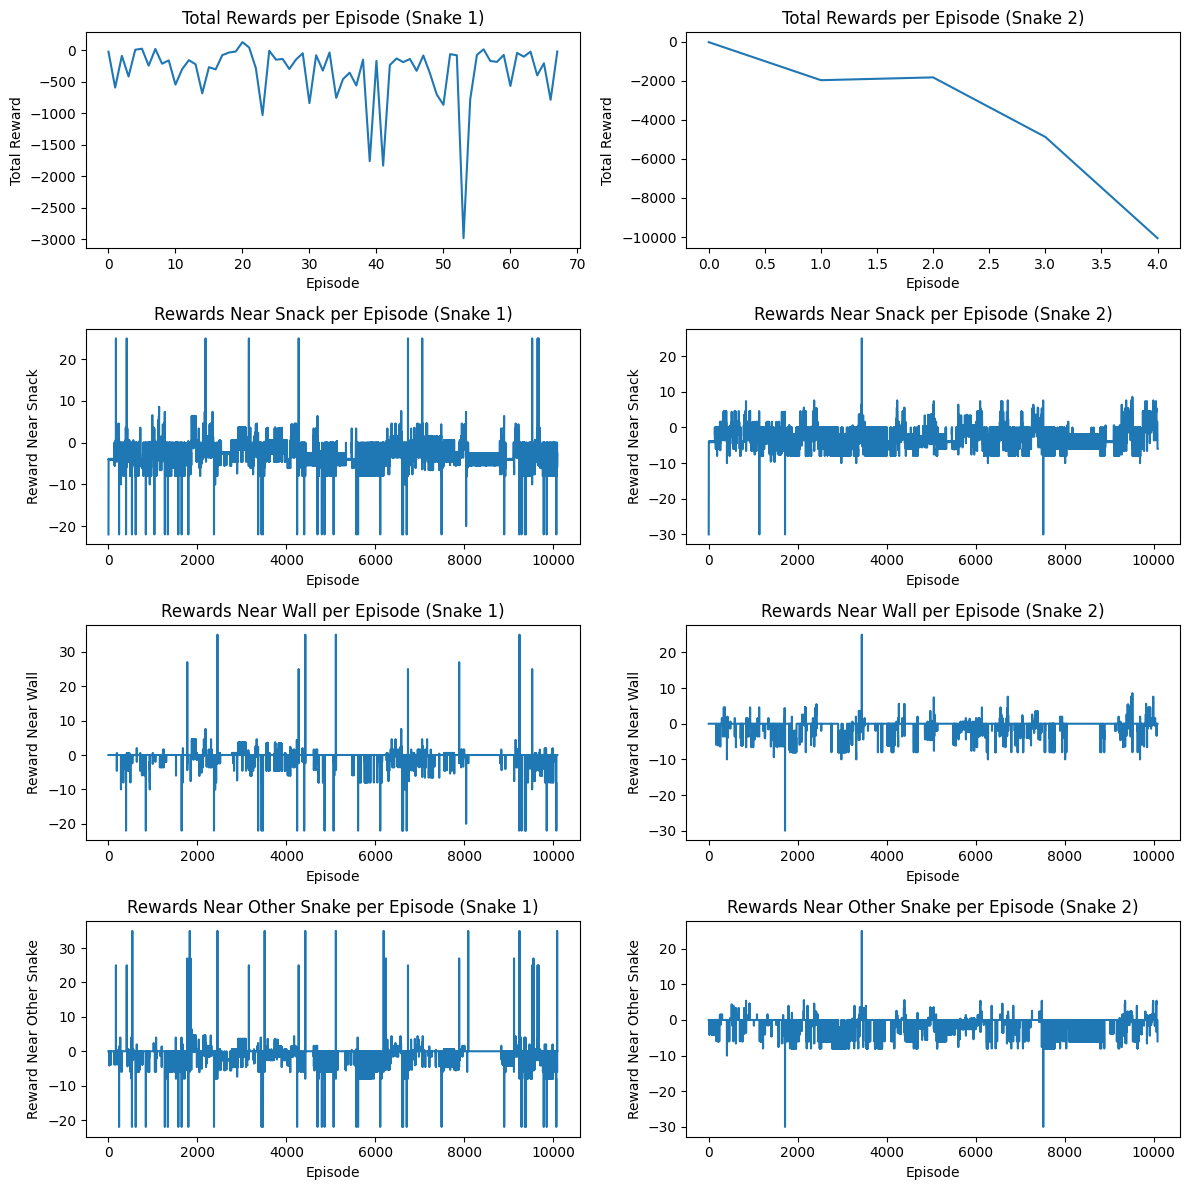

snake 1 wins 4 | snake 2 wins 1


error: display Surface quit

: 

In [8]:
main()

#### <p align="justify"><font size="6" color="#d62b5b">Conclusion</font></p>
<p align="justify">
In this project, we developed and optimized a reinforcement learning-based agent to play a 1v1 snake game. Our approach utilized the approximate Q-learning technique, where the agent learned to make decisions based on state-action pairs and updated its weights accordingly to maximize cumulative rewards over time.

We started by defining the state features that capture the essential aspects of the game environment, such as distances to walls, the snack, and the opponent snake. We also included local vision around the snake to provide a comprehensive representation of the state. The Q-value for each state-action pair was approximated using a linear combination of these features and their corresponding weights.

Key components of our implementation included:
1. **Feature Extraction**: We defined a robust feature extraction method to capture the state of the game. This included distances to critical objects and a vision grid around the snake.
2. **Action Selection**: The agent used an epsilon-greedy policy to balance exploration and exploitation. This allowed the snake to explore different actions while gradually focusing on the optimal policy as it learned.
3. **Collision Avoidance**: We incorporated checks to avoid head-on collisions and tail collisions, ensuring that the agent could make safer moves.
4. **Reward Function**: The reward function was carefully designed to encourage desirable behaviors such as moving towards the snack, avoiding collisions, and maintaining an optimal length. We provided higher rewards for smaller snakes to seek the snack and penalized unnecessary movements and risky behaviors.
5. **Weight Updates**: The weights were updated using the Temporal Difference (TD) error, which measured the difference between the predicted and target Q-values. This iterative process allowed the agent to refine its policy over time.

Through iterative development and testing, we fine-tuned the parameters and logic to create a competitive and intelligent snake agent. The resulting agent demonstrated effective strategies, such as trapping the opponent and prioritizing growth when smaller, leading to a well-rounded performance in the 1v1 snake game environment.

Overall, this project showcased the power of approximate Q-learning in developing autonomous agents capable of learning complex behaviors through interaction with their environment. The techniques and insights gained from this project can be extended to other reinforcement learning applications, further advancing the field of artificial intelligence.
</p>